# Fit atmosphere parameters Airmass, VAOD, PWV, O3, including clouds OD

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 15th 2020
- update : September 19th 2020

# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
from astropy.table import Table

In [4]:
from scipy import interpolate

In [5]:
from scipy.stats import rayleigh,beta,gamma,uniform

In [6]:
# analytic for removing rayleigh
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [7]:
import libatmscattering as atm

In [8]:
import seaborn as sns

In [9]:
# pysynphot
import pysynphot as S

In [10]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [11]:
import scipy.special as sp

In [12]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

In [13]:
import libLSSTFiltersKG as lsst

liblsstfilter_path= ../../data/lsst/LSSTFiltersKG


In [14]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

# Pre defined Functions

In [15]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

## Functions to select the CALSPEC

In [16]:
def GetListOfCalspec(file_sedsummary="sed/table_summary_allcalspec_torenorm.fits"):
    """
    GetListOfCalspec()
    
    the file include SED fro which color term has been caculated 
    in /examples_sed/calspec/ViewCalspecColors.ipynb
    
    - input:
      file_sedsummary : filename of SED summary
      
    - output:
      t : astropy table of summary 
    """

    t=Table.read(file_sedsummary)
    return t

In [17]:
def SelectFewSED(t):
    """
    SelectFewSED(t)
    
    input : 
     - t astropy table of SED
     
    output :
    - t_selected : table of presselected SED
     
    """
    
    all_colors=t["VmI"]
    
    
    # list of target colors
    target_VmI=np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
    NBVmItarget=len(target_VmI)
    
    filesselected_index=np.zeros(NBVmItarget)
    filesselected_VmI=np.zeros(NBVmItarget)
    
    idx=0
    for vmi in target_VmI:
        thevmi,theidx=find_nearest(all_colors,vmi)
        #print(thevmi,theidx)
        filesselected_index[idx]=int(theidx)
        filesselected_VmI[idx]=thevmi
        idx+=1  
        
    t_selected=Table(t[0])
    for idx in filesselected_index[1:]:
        t_selected.add_row(t[int(idx)])
        
    return t_selected
    

In [18]:
def plot_sed(t,ax):
    """
    
    plot_sed(t, ax) : Plot SED from the astropy table t

    input:
        - t : tables of SED
        - ax : matplotlib axis

    """
    
    NBFILES=len(t)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)
    
    idx=0
    
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')

    for filename in t["FILES"]:
    
        # read the calspec file
        fullfilename=os.path.join(path_sed_calspec,filename)
        
        if filename=="flat":
            spec=flatsp
            spec_norm=spec
        else:
            spec=S.FileSpectrum(fullfilename)
        
        spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
        spec_norm.convert('photlam')
        #spec_norm.convert('nm')    
        
        #WLMINSEL=340.
        #WLMAXSEL=1100.


        magV=t["magV"][idx]
        label=t["OBJNAME"][idx]+" ( "+t["SP_TYPE"][idx]+" ) "+" magV = {:.2g}".format(magV) +" v-i ={:.2f}".format(t["VmI"][idx])
        
        
        
        #X= spec_norm.wave[wavelengths_indexes]    
        #Y= spec_norm.flux[wavelengths_indexes]  
        
        X= spec_norm.wave   
        Y= spec_norm.flux 
        
        wavelengths_indexes=np.where(np.logical_and(spec_norm.wave>WLMINSEL*10, spec_norm.wave<WLMAXSEL*10))[0]
        
        
        #if filename!="flat":
        cm=ax.plot(X[wavelengths_indexes], Y[wavelengths_indexes],color=all_colors[idx],label=label)
        
        idx+=1
    
    #ax.set_xlim(3500.,11000.)
    #ax.set_ylim(0.,3.)
    ax.legend()
    ax.grid()


    xlabel=' $\\lambda$ (Angstrom)'
    ylabel=' Flux (photlam) normalised to Mag-10'
    ax.set_xlabel(xlabel,fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.set_title("Preselected CALSPEC relative SED")
    
    return cm

    
    

## Functions to build spectrum 

In [19]:
def GetSpectra(sed,wl_atm,atm_transmission, order2=False,cut=False):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
     - order2 : flag to compute the atmospheric transmission
     
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
    spectra2=np.zeros_like(atm_transmission)  # order 2
    
    wl_atm_ang=10*wl_atm
    
    
    
    # quantum efficiency
    wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")
    bp_qe= S.ArrayBandpass(wl_ccd*10.,ccdqe, name='QE')
    
    
    
    # passband for atmosphere
    Natm=atm_transmission.shape[0]
    all_bp_atm=[]
    for i_atm in np.arange(Natm):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
    # Hologram transmission (analytic)
    X0=10000 # in antstrom
    X=wl0
    X2=np.sort(np.unique(np.concatenate((wl0/2,wl0)))) 
    Eff_holo=sp.jv(1, X0/X)**2
    Eff_holo2=sp.jv(2, X0/X2)**2
    
    bp_holo_order1= S.ArrayBandpass(X,Eff_holo, name='Holo')
    bp_holo_order2= S.ArrayBandpass(X2,Eff_holo2, name='Holo2')
    
    all_obs1=[]
    all_obs2=[]
    
    # compute spectra for order 1 and order 2
    for i_atm in np.arange(Natm):
        bp_all_order1=bp_qe*all_bp_atm[i_atm]* bp_holo_order1
        bp_all_order2=bp_qe*all_bp_atm[i_atm]* bp_holo_order2

        obs1 = S.Observation(sed, bp_all_order1,force='taper') # order 1
        obs2 = S.Observation(sed, bp_all_order2,force='taper') # order 2
    
        all_obs1.append(obs1)
        all_obs2.append(obs2)
        
   
    for i_atm in np.arange(Natm):
        obs1=all_obs1[i_atm]
        func_order1 = interpolate.interp1d(obs1.binwave,obs1.binflux,bounds_error=False,fill_value=(0,0))
    
        spectra[i_atm,:]=func_order1(wl_atm_ang) 
    
        obs2=all_obs2[i_atm]
        func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,bounds_error=False,fill_value=(0,0))
        spectra2[i_atm,:]=func_order2(wl_atm_ang) 
    
    if cut:
         wlcut_indexes = np.where(wl_atm_ang<7600)[0]
         spectra2[:,wlcut_indexes]=0
        
        
    # add order 1 + order 2    
    if order2:
        spectra=spectra+spectra2
        
    spectra=spectra*10 # to get per unit of nm
    spectra2=spectra2*10
    
    return spectra,spectra2
    
    

In [20]:
if 0:
    spectra,spectra2=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm[:22,:],order2=True)
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(20):
        ax.plot(wl,spectra[idx,:])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()
    
    ax = fig.add_subplot(122)
    for idx in np.arange(20):
        ax.plot(wl,spectra2[idx,:])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()

## Functions for Plotting

In [21]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot estimated parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        r'$\mu$={:3.2g}'.format(mu),
        r'$median$={:3.2g}'.format(median),
        r'$\sigma$={:3.2g}'.format(sigma)))
        
       
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        
        
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
       
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])

    
    ax.ticklabel_format(axis='y',style='sci', 
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [22]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=10):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    '$\mu$={:.3g}'.format(mu),
    '$median$={:.3g}'.format(median),
    '$\sigma$={:.3g}'.format(sigma)))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_xlim(mu-nsig*sigma,mu+nsig*sigma)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    ax.ticklabel_format(axis='x', 
                          style='sci',
                          scilimits=(-3,-3), 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [23]:
def plotcorrelation(ax,all_Y):
    """
    """
    
    df=pd.DataFrame(data=all_Y,columns=['VAOD', 'PWV', 'OZONE',"CLD-OD"])
    Var_Corr = df.corr()
    mask_ut=np.triu(np.ones(Var_Corr.shape)).astype(np.bool)
    mask_lt=np.logical_not(np.tril(np.ones(Var_Corr.shape)).astype(np.bool))
    
    sns.heatmap(Var_Corr,mask=mask_lt,vmin=0, vmax=1 ,xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,ax=ax,cmap="jet")

In [24]:
#-----------------------------------------------------------------------------------------------------------------------
def plot_ml_result(Yin,Yout,mode,title):
    """
    plot_ml_result(Yin,Yout,mode,title)

    :param Yin:
    :param Yout:
    :param mode:
    :param title:
    :return:
    """

    fig = plt.figure(figsize=(8.5, 7.5))
    ax = fig.add_subplot(221)
    plot_param(0, ax, Yin, Yout, mode)

    ax = fig.add_subplot(222)
    plot_param(1, ax,Yin, Yout, mode)

    ax = fig.add_subplot(223)
    plot_param(2, ax, Yin, Yout, mode)

    ax = fig.add_subplot(224)
    plot_param(3, ax, Yin, Yout, mode)

    plt.tight_layout()
    plt.suptitle(title, Y=1.02, fontsize=18)
    plt.show()
#--------------------------------------------

In [25]:
def histo_ml_result(Yin, Yout, title):
    """

    :param Yin:
    :param Yout:
    :param mode:
    :param title:
    :return:
    """

    fig = plt.figure(figsize=(8.5, 7.5))
    ax = fig.add_subplot(221)
    plot_param_histo(0, ax, Yin, Yout)

    ax = fig.add_subplot(222)
    plot_param_histo(1, ax, Yin, Yout)

    ax = fig.add_subplot(223)
    plot_param_histo(2, ax, Yin, Yout)

    ax = fig.add_subplot(224)
    plot_param_histo(3, ax, Yin, Yout)

    plt.tight_layout()
    plt.suptitle(title, Y=1.02, fontsize=18)
    plt.show()
#---------------------------------------------

In [26]:
def plot_regularisation_coeff(alphas,alpha0,allcoefs,title):
    """

    plot_regularisation_coeff(alpha,all_coeff,title) : plot coefficient vrt regularisation parameter

    :param alphas: regularisation parameters
    : param alpha0 : vertical line
    :param allcoefs: coefficient
    :param title: title
    :return:
    """

    N = allcoefs.shape[2] # number of coefficients
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig = plt.figure(figsize=(12, 8))

    ax1 = fig.add_subplot(221)
    for idx in np.arange(allcoefs.shape[2]):
        ax1.plot(alphas, allcoefs[:, 0, idx], color=all_colors[idx])
    ax1.set_xscale('log')
    ax1.axvline(x=alpha0, color='red')
    ax1.set_ylabel('weights - vaod')
    ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
    ax1.grid(True)
    ax1.set_title(title)

    ax2 = fig.add_subplot(222, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax2.plot(alphas, allcoefs[:, 1, idx], color=all_colors[idx])
    ax2.axvline(x=alpha0, color='red')
    ax2.set_xscale('log')
    ax2.set_ylabel('weights - H2O')
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
    ax2.grid(True)

    ax3 = fig.add_subplot(223, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax3.plot(alphas, allcoefs[:, 2, idx], color=all_colors[idx])
    ax3.axvline(x=alpha0, color='red')
    ax3.set_ylabel('weights - O3')
    ax3.set_xscale('log')
    ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
    ax3.grid(True)

    ax4 = fig.add_subplot(224, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax4.plot(alphas, allcoefs[:, 3, idx], color=all_colors[idx])
    ax4.axvline(x=alpha0, color='red')
    ax4.set_ylabel('weights - CLD')
    ax4.set_xscale('log')
    # ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
    ax4.set_xlim(ax4.get_xlim())  # reverse axis
    ax4.grid(True)

    plt.xlabel('alpha')
    plt.axis('tight')

    plt.tight_layout()
    plt.show()



# GetAtmTransparency

In [27]:
def GetAtmTransparency(inputdir,filelist):
    """
    GetAtmTransparency(inputdir, filelist): retrieve atmospheric transparency from simulation

    input arguments:
     - inputdir : input directory
     - filelist : list of file to read
    """
    
    filename=filelist[0]
    full_inputfilename=os.path.join(inputdir,filename)
    hduin = fits.open(full_inputfilename)
    
    headerin=hduin[0].header
    datain=hduin[0].data
    
    hdr=headerin
    NSIMH=hdr['NBATMSIM']
    idx_num = hdr['ID_NUM']
    idx_am = hdr['ID_AM']
    idx_vaod=hdr['ID_VAOD']
    idx_pwv= hdr['ID_PWV']
    idx_o3=hdr['ID_O3']
    idx_cld=hdr['ID_CLD']
    idx_res= hdr['ID_RES']
    
    wl=datain[0,idx_res:]
    
    hduin.close() 
    
    all_data=[]
    # loop on files to extract data
    for file in filelist:
        full_inputfilename=os.path.join(inputdir,file)
        hdu = fits.open(full_inputfilename)
       
        datain=hdu[0].data
        all_data.append(datain[1:,:])
        hdu.close
        
    dataout=np.concatenate(all_data,axis=0)
    
    return wl,dataout,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,headerin
        

# Initialisation

In [28]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))

LA time: 12:35:31
NY time: 15:35:31
London time: 20:35:31
Paris time: 21:35:31


# Configuration

In [29]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')


In [30]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-09-22 21:35:31,378 MacBook-Pro-de-admin.local __main__[79321] INFO LA time:12:35:31
2020-09-22 21:35:31,379 MacBook-Pro-de-admin.local __main__[79321] INFO NY time:15:35:31
2020-09-22 21:35:31,380 MacBook-Pro-de-admin.local __main__[79321] INFO London time:20:35:31
2020-09-22 21:35:31,382 MacBook-Pro-de-admin.local __main__[79321] INFO Paris time:21:35:31
2020-09-22 21:35:31,382 MacBook-Pro-de-admin.local __main__[79321] INFO ************************ START *********************


In [31]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [32]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-09-22 21:35:31,401 MacBook-Pro-de-admin.local __main__[79321] INFO Configuration file : config/default.ini


In [33]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-09-22 21:35:31,408 MacBook-Pro-de-admin.local __main__[79321] INFO 1) Configuration


In [34]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [35]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)


if 'MLFIT'in config_section:
    input_file = config['MLFIT']['inputfile']
    input_dir = config['MLFIT']['inputdir']

    packetsize = int(config['MLFIT']['packetsize'])
    maxnbpacket = int(config['MLFIT']['maxnbpacket'])

    input_file_split=input_file.split(".")    
    basefilename=input_file_split[0]
    extendfilename=input_file_split[1]
else:
    msg="Configuration file : Missing section MLFIT in config file {config_filename} !"
    logger.error(msg)
    

# Atmospheric transparency file and selection

In [36]:
all_files = os.listdir(input_dir)
sorted_files=sorted(all_files)

In [37]:
# search string
search_str="^"+f"{basefilename}.*fits$"

In [38]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

### Keep a limited number of input files

In [39]:
if maxnbpacket>0:
    selected_files=selected_files[:maxnbpacket]

In [40]:
NFiles=len(selected_files)

# Read simulated atmospheric transparency

In [41]:
wl,datain,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,header=GetAtmTransparency(input_dir,selected_files)

In [42]:
logger.info(header)

2020-09-22 21:35:32,157 MacBook-Pro-de-admin.local __main__[79321] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  957                                                  NAXIS2  =                  101                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [43]:
idx_cld

5

In [44]:
num=datain[0:,idx_num]
airmass=datain[0:,idx_am]
vaod=datain[0:,idx_vaod] # vertical aerosol depth
pwv=datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone=datain[0:,idx_o3]     # ozone
cld=datain[0:,idx_cld]   # clouds (not us

In [45]:
transm=datain[:,idx_res:]

In [46]:
wl.shape

(951,)

In [47]:
transm.shape

(10000, 951)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
2020-09-22 21:35:33,267 MacBook-Pro-de-admin.local matplotlib.legend[79321] WARNING No handles with labels found to put in legend.


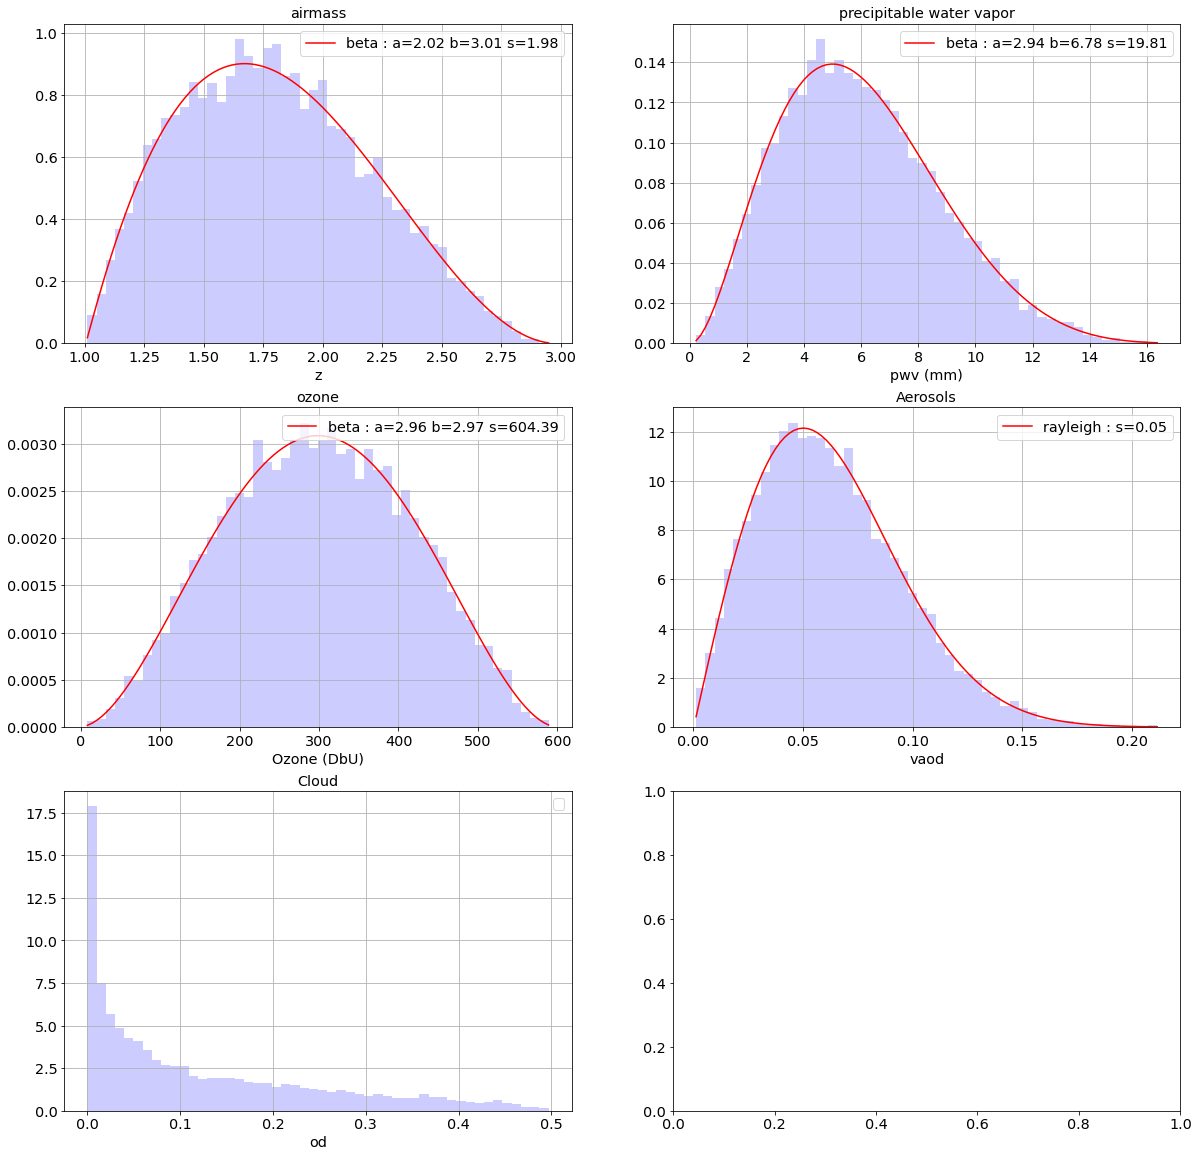

In [48]:
def GetDistribFromName(name):
    """
    
    GetDistribFromName(name): Get distribution from name in config file
    
    input arg:
    
    - name : string name of the distribution
    
    """
    
    rayleigh,beta,gamma,uniform
    
    if name=="rayleigh":
        return rayleigh
    elif name=="beta":
        return beta
    elif name=="gamma":
        return gamma
    else:
        return uniform
    


if FLAG_PLOT:
    fig=plt.figure(figsize=(20,20))
    ax1=fig.add_subplot(321)
    ax2=fig.add_subplot(322)
    ax3=fig.add_subplot(323)
    ax4=fig.add_subplot(324)
    ax5=fig.add_subplot(325)
    ax6=fig.add_subplot(326)

    
    
    ax1.hist(airmass,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax1.set_title("airmass")
    ax1.set_xlabel("z")
    
    
    if 'AIRMASS' in config_section:
        distrib_name= config['AIRMASS']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(airmass)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(airmass.min(),airmass.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        ax1.plot(x,pdf,"r-",label=label)
        ax1.legend()
        ax1.grid()
    
    
    
    
    ax2.hist(pwv,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax2.set_title("precipitable water vapor")
    ax2.set_xlabel("pwv (mm)")
    
    if 'PWV' in config_section:
        distrib_name= config['PWV']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(pwv)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(pwv.min(),pwv.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax2.plot(x,pdf,"r-",label=label)
        ax2.legend()
        ax2.grid()
    
        
    
    ax3.hist(ozone,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax3.set_title("ozone")
    ax3.set_xlabel("Ozone (DbU)")
    
    if 'OZONE' in config_section:
        distrib_name= config['OZONE']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(ozone)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(ozone.min(),ozone.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax3.plot(x,pdf,"r-",label=label)
        ax3.legend()
        ax3.grid()
    
    
    
    ax4.hist(vaod,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax4.set_title("Aerosols")
    ax4.set_xlabel("vaod")
    
    
    if 'AEROSOL' in config_section:
        distrib_name= config['AEROSOL']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(vaod)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(vaod.min(),vaod.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        ax4.plot(x,pdf,"r-",label=label)
        ax4.legend()
        ax4.grid()
    
    
    
    ax5.hist(cld,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax5.set_title("Cloud")
    ax5.set_xlabel("od")
    
    
    if 'CLOUD' in config_section:
        distrib_name= config['CLOUD']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(cld)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(cld.min(),cld.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        #ax5.plot(x,pdf,"r-",label=label)
        ax5.legend()
        ax5.grid()
    


### Select wavelength range

Truncate wavelength

In [49]:
WLMINSEL=340.
WLMAXSEL=1100.

In [50]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [51]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [52]:
wl=wl[indexes_selected]
transm_tot=transm[:,indexes_selected]

### Remove rayleigh component

In [53]:
od_rayl=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od_rayl)

In [54]:
transm=transm_tot/att_rayleigh

### Not removing the rayleigh

In [55]:
transm=transm_tot

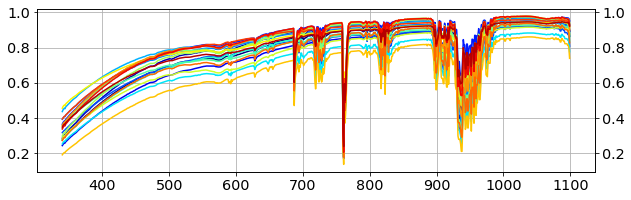

In [56]:
if FLAG_PLOT:
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,transm[idx,:],c=all_colors[idx])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()

In [57]:
NWL=wl.shape[0]

In [58]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data : X and Y

In [59]:
airmassarr=airmass[:,np.newaxis]
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=ozone[:,np.newaxis]
cldarr=cld[:,np.newaxis]

## Clouds

## clouds in input data

In [60]:
transm_cloud=np.exp(-cld*airmass)
transm_cloud_arr=np.exp(-cldarr*airmassarr)

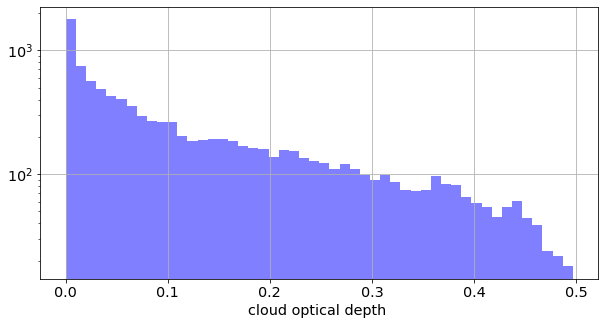

In [61]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,5))

    ax = fig.add_subplot(111)
    ax.hist(cld,bins=50,facecolor="b",label="in data",alpha=0.5)
    ax.set_yscale('log')
    ax.set_xlabel("cloud optical depth ")
    ax.grid()


### concatenate VAOD,PWV, Ozone

In [62]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)
Ylabel=["vaod","pwv","ozone","cld"]

### Use magnitudes for X

In [63]:
t=GetListOfCalspec()
t_sel=SelectFewSED(t)


In [64]:
t_sel

OBJNAME,RA,DEC,SP_TYPE,SP_QUAL,magU,magB,magV,magR,magI,FILES,calcU,calcB,calcV,calcR,calcI,factor,VmI
bytes10,float64,float64,bytes12,bytes1,float64,float32,float64,float64,float64,bytes27,float64,float64,float64,float64,float64,float64,float64
NGC7293,337.411,-20.837,DAO.5,C,11.894,13.158,13.524,13.689,13.898,ngc7293_005.fits,11.917,13.180,13.538,13.734,14.234,26.01,-0.697
G93-48,328.106,2.389,DA2.8,C,11.942,12.732,12.743,12.839,12.938,g93_48_004.fits,11.982,12.717,12.728,12.836,13.234,12.34,-0.506
HZ4,58.842,9.788,DA3.4,C,13.917,14.592,14.506,14.580,14.642,hz4_stis_005.fits,13.961,14.593,14.473,14.569,14.723,61.551,-0.250
ALPHA_LYR,279.235,38.784,A0Va,C,0.030,0.030,0.030,0.070,0.100,alpha_lyr_stis_008.fits,0.021,0.017,0.009,0.000,-0.004,0.00010079,0.013
HD163466,268.106,60.396,A2,E,100000000000000000000.000,7.040,6.850,100000000000000000000.000,100000000000000000000.000,hd163466_stis_004.fits,7.161,7.036,6.839,6.694,6.589,0.054409,0.251
HD074000,130.212,-16.345,F2,D,9.840,10.090,9.660,100000000000000000000.000,100000000000000000000.000,hd074000_stis_003.fits,9.852,10.065,9.645,9.269,8.987,0.72107,0.658
HD106252,183.373,10.042,G0,E,100000000000000000000.000,8.000,100000000000000000000.000,7.000,100000000000000000000.000,hd106252_stis_004.fits,8.117,8.020,7.403,6.957,6.653,0.091453,0.750
FLAT,0.000,0.000,flat,0,9.721,10.369,10.000,9.501,9.001,flat,9.721,10.369,10.000,9.501,9.001,1,0.999


### Show examples of SED to use

2020-09-22 21:35:35,964 MacBook-Pro-de-admin.local astropy[79321] WARNING VerifyWarning: Invalid keyword for column 1: Column disp option (TDISPn) failed verification: Format 26A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-22 21:35:35,968 MacBook-Pro-de-admin.local astropy[79321] WARNING VerifyWarning: Invalid keyword for column 2: Column disp option (TDISPn) failed verification: Format 18A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-22 21:35:35,971 MacBook-Pro-de-admin.local astropy[79321] WARNING VerifyWarning: Invalid keyword for column 3: Column disp option (TDISPn) failed verification: Format 56A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-22 21:35:35,975 MacBook-Pro-de-admin.local astropy[79321] WARNING VerifyWarning: Invalid keyword for column 4: Column disp option (

Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 6265 bins contained negative fluxes; they have been set to zero.


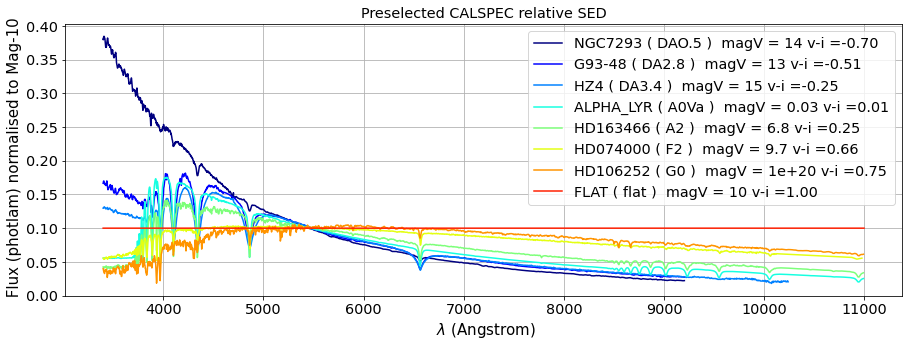

In [65]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(15,5))
    ax=fig.add_subplot(111)
    plot_sed(t_sel,ax)
    plt.show()

### Get the Spectrum

In [66]:
idx_sed_sel=3
sed_filename=t_sel[idx_sed_sel]["FILES"]
sed_objname=t_sel[idx_sed_sel]["OBJNAME"]
sed_fullfilename=os.path.join(path_sed_calspec,sed_filename)
order2=True
if order2:
    specarrayfile="spec_"+sed_objname+"_ord12.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
else:
    specarrayfile="spec_"+sed_objname+"_ord1.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"

In [67]:
specarrayfile

'spec_ALPHA_LYR_ord12.npy'

In [68]:
specarrayfile2

'spec2_ALPHA_LYR_ord2.npy'

In [69]:
if sed_filename=="flat":
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')
    spec=flatsp
else:
    spec=S.FileSpectrum(sed_fullfilename)
        
spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
spec_norm.convert('photlam')

In [70]:
if not os.path.isfile(specarrayfile) or not os.path.isfile(specarrayfile2) :
    spectra,spectra2=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm,order2=order2)
    np.save(specarrayfile,spectra)
    np.save(specarrayfile2,spectra2)   
else:
    spectra=np.load(specarrayfile)
    spectra2=np.load(specarrayfile2)

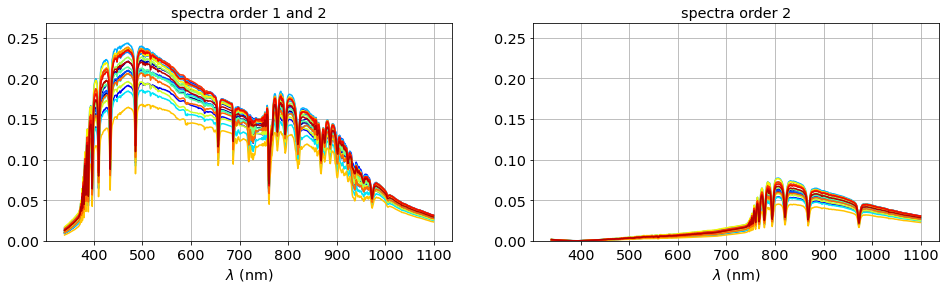

In [71]:
if FLAG_PLOT:
    
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(N):
        if spectra[idx,:].max()>themax:
            themax=spectra[idx,:].max()
        ax.plot(wl,spectra[idx,:],color=all_colors[idx])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_title(title_spec1)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(N):
        ax.plot(wl,spectra2[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec2)
    ax.grid()

In [72]:
FLAG_MAG=True
if FLAG_MAG:
    X=-2.5*np.log10(spectra*transm_cloud_arr)/airmassarr
else:
    X=spectra*transm_cloud_arr

In [73]:
X.shape

(10000, 760)

### Check transmission or spectrum

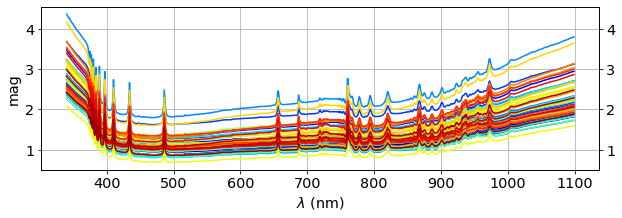

In [74]:
if FLAG_PLOT:
    N=50
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,X[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("mag")
    ax.grid()
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())

# Correlation coefficient X - Y

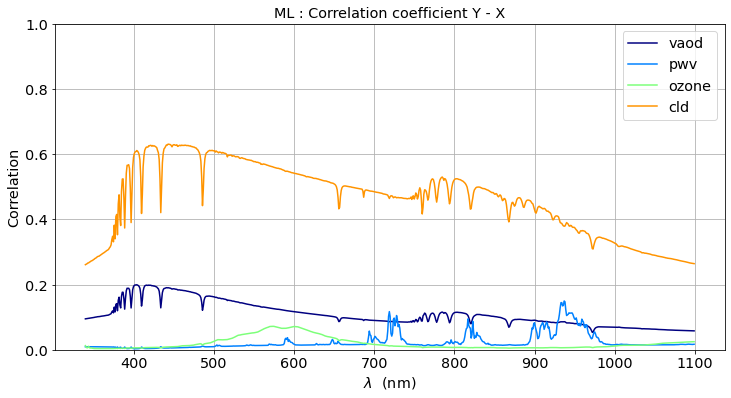

In [75]:
if FLAG_PLOT:
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111) 
    
    Ny=Y.shape[1]
    Nx=X.shape[1]
    
    N=Ny
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl,corr[iy,:],color=all_colors[iy],label=Ylabel[iy])
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation")
    ax.set_title("ML : Correlation coefficient Y - X")
    ax.grid()
    ax.set_ylim(0,1)

## Splitting

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [77]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [78]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [79]:
FLAG_SCALING=True

In [80]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [81]:
scaler_X.mean_.shape

(760,)

In [82]:
scaler_X.scale_.shape

(760,)

In [83]:
scaler_Y.mean_.shape

(4,)

In [84]:
scaler_Y.scale_.shape

(4,)

In [85]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

In [86]:
X_train_scaled.shape

(6000, 760)

In [87]:
X_val_scaled.shape 

(2000, 760)

In [88]:
X_test_scaled.shape 

(2000, 760)

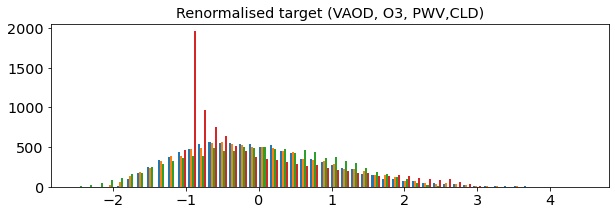

In [89]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
    ax.set_title("Renormalised target (VAOD, O3, PWV,CLD)")

## Linear regression model

In [90]:
if 'LINEARREGRESSION' in config_section:
    FLAG_LINEARREGRESSION = bool(int(config['LINEARREGRESSION']['FLAG_LINEARREGRESSION']))
    FLAG_LINEARREGRESSION_RIDGE = bool(int(config['LINEARREGRESSION']['FLAG_LINEARREGRESSION_RIDGE']))
    FLAG_LINEARREGRESSION_LASSO = bool(int(config['LINEARREGRESSION']['FLAG_LINEARREGRESSION_LASSO']))
else:
    msg = f"Configuration file : Missing section LINEARREGRESSION in config file {config_filename} !"
    logger.error(msg)
    sys.exit()


In [91]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [92]:
reg = linear_model.LinearRegression()

In [93]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [94]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[-6.24014439e+02  1.16103131e+02  8.09056020e+02 ... -4.44680873e+05
   1.08593557e+05 -1.26419695e+04]
 [ 1.79742365e-02  5.68219831e-01 -1.13610205e+00 ... -8.46521132e+03
   1.75425091e+03 -1.59690532e+02]
 [ 2.88464094e+00 -2.66296686e+00 -2.65890464e+00 ...  2.08740450e+03
  -5.68003164e+02  6.51580896e+01]
 [ 1.65089015e+02 -3.10704426e+01 -2.14352690e+02 ...  1.17694107e+05
  -2.87394408e+04  3.34520073e+03]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


In [95]:
X_train_scaled.shape

(6000, 760)

In [96]:
regr.coef_.shape

(4, 760)

In [97]:
nb_tot_test = len(Y_test)
nb_tot_train = len(Y_train)

nsamples_test = np.arange(10, nb_tot_test, 100)
nsamples_train = np.arange(10, nb_tot_train, 100)

In [98]:
##################################################
# Linear Regression : Learning curve
##################################################

if FLAG_LINEARREGRESSION:
    logger.info('4) Linear Regression, no regularisation')
    
    all_MSE_train = np.zeros(len(nsamples_train))
    all_MSE_test = np.zeros(len(nsamples_test))
    all_MSE_test_full = np.zeros(len(nsamples_train))

    count = 0
    for n in nsamples_train:

        regr = linear_model.LinearRegression(fit_intercept=True)

        if FLAG_SCALING:
            X_train_cut = np.copy(X_train_scaled[:n, :])
            Y_train_cut = np.copy(Y_train_scaled[:n, :])
            if n in nsamples_test:
                X_test_cut = np.copy(X_test_scaled[:n, :])
                Y_test_cut = np.copy(Y_test_scaled[:n, :])
        else:
            X_train_cut = X_train[:n, :]
            Y_train_cut = Y_train[:n, :]
            if n in nsamples_test:
                X_test_cut = X_test[:n, :]
                Y_test_cut = Y_test[:n, :]

        # does the fit
        regr.fit(X_train_cut, Y_train_cut)

        # calculate metric
        # Make predictions using the testing set
        Y_pred_train = regr.predict(X_train_cut)
        if n in nsamples_test:
            Y_pred_test = regr.predict(X_test_cut)

        if FLAG_SCALING:
            Y_pred_test_full = regr.predict(np.copy(X_test_scaled))
        else:
            Y_pred_test_full = regr.predict(np.copy(X_test))

        MSE_train = mean_squared_error(Y_train_cut, Y_pred_train)

        if n in nsamples_test:
            MSE_test = mean_squared_error(Y_test_cut, Y_pred_test)

        if FLAG_SCALING:
            MSE_test_full = mean_squared_error(Y_test_scaled, Y_pred_test_full)
        else:
            MSE_test_full = mean_squared_error(Y_test, Y_pred_test_full)

        all_MSE_train[count] = MSE_train
        all_MSE_test_full[count] = MSE_test_full

        if n in nsamples_test:
            all_MSE_test[count] = MSE_test

        count += 1
        # end of loop

2020-09-22 21:35:40,312 MacBook-Pro-de-admin.local __main__[79321] INFO 4) Linear Regression, no regularisation


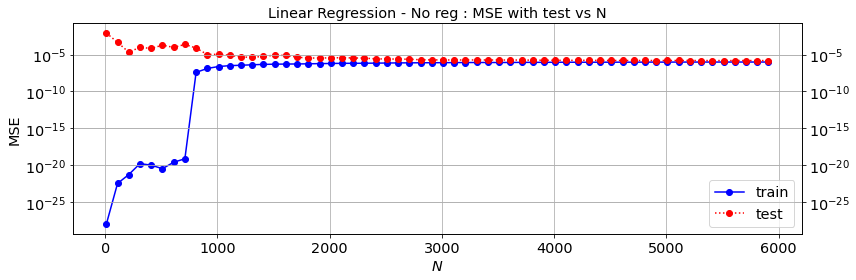

In [99]:
if FLAG_LINEARREGRESSION and FLAG_PLOT:
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(111)
    ax.plot(nsamples_train, all_MSE_train, 'b-o', label="train")
    # ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
    ax.plot(nsamples_train, all_MSE_test_full, 'r:o', label="test")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel("$N$")
    ax.set_ylabel("MSE")
    ax.set_title("Linear Regression - No reg : MSE with test vs N")
    ax.grid()
    # ax.set_ylim(1e-6,1e-2)
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax1.set_yscale("log")
    ax1.grid()
    plt.tight_layout()
    plt.show()


In [100]:
##############
# Final fit
#############

if FLAG_LINEARREGRESSION:
    
    regr = linear_model.LinearRegression(fit_intercept=True)

    if FLAG_SCALING:
        regr.fit(X_train_scaled, Y_train_scaled)
    else:
        regr.fit(X_train, Y_train)

    # calculate metric
    # Make predictions using the testing set

    if FLAG_SCALING:
        Y_pred_test = regr.predict(X_test_scaled)
        Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
        DY = Y_pred_test - Y_test_scaled
    else:
        Y_pred_test = regr.predict(X_test)
        DY = Y_pred_test - Y_test

    if FLAG_SCALING:
        # The mean squared error
        msg='Mean squared error: %.5f' % mean_squared_error(Y_test_scaled, Y_pred_test)
        logger.info(msg)
        # The coefficient of determination: 1 is perfect prediction
        msg='Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test)
        logger.info(msg)
        # Explained variance : 1 is perfect prediction
        msg='Explained variance: %.5f' % explained_variance_score(Y_test_scaled, Y_pred_test)
        logger.info(msg)

    else:
        # The mean squared error
        msg='Mean squared error: %.5f' % mean_squared_error(Y_test, Y_pred_test)
        logger.info(msg)
        # The coefficient of determination: 1 is perfect prediction
        msg='Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test)
        logger.info(msg)
        # Explained variance : 1 is perfect prediction
        msg='Explained variance: %.5f' % explained_variance_score(Y_test, Y_pred_test)
        logger.info(msg)

2020-09-22 21:35:55,399 MacBook-Pro-de-admin.local __main__[79321] INFO Mean squared error: 0.00000
2020-09-22 21:35:55,401 MacBook-Pro-de-admin.local __main__[79321] INFO Coefficient of determination: 1.00000
2020-09-22 21:35:55,404 MacBook-Pro-de-admin.local __main__[79321] INFO Explained variance: 1.00000


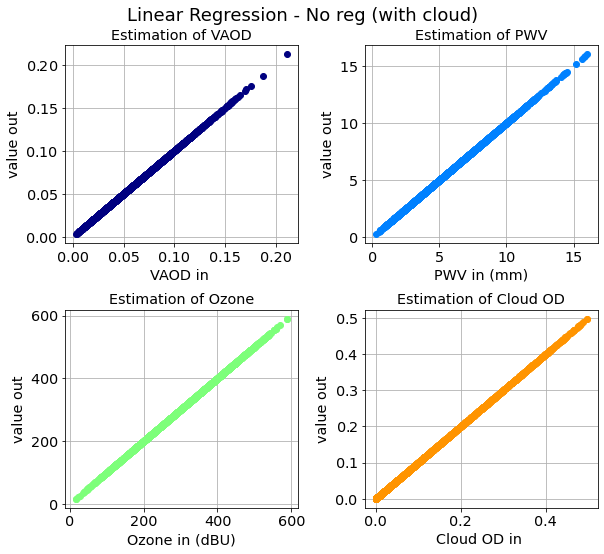

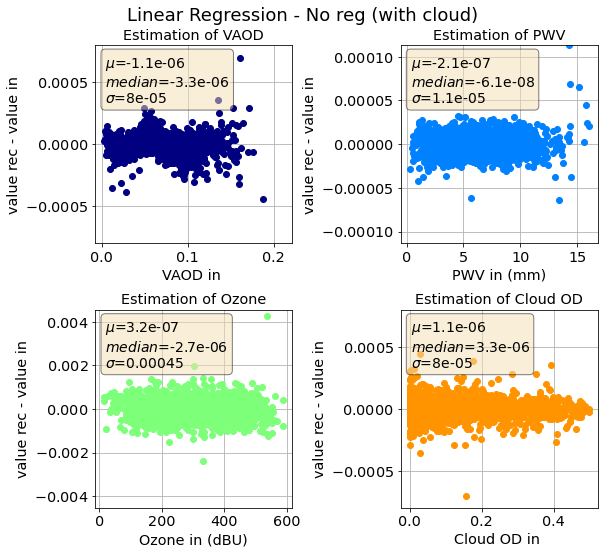

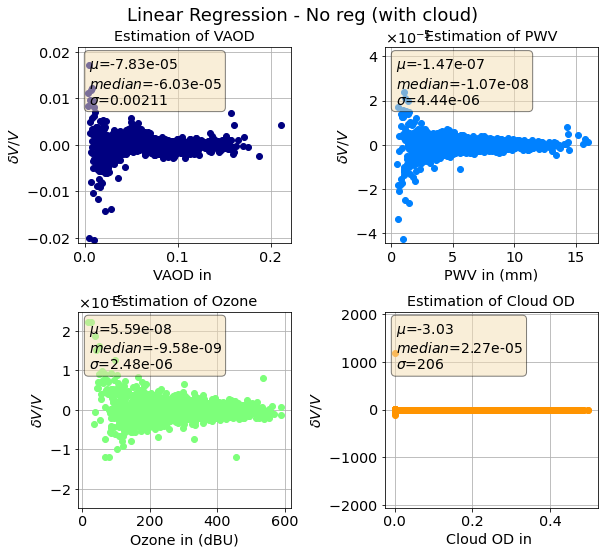

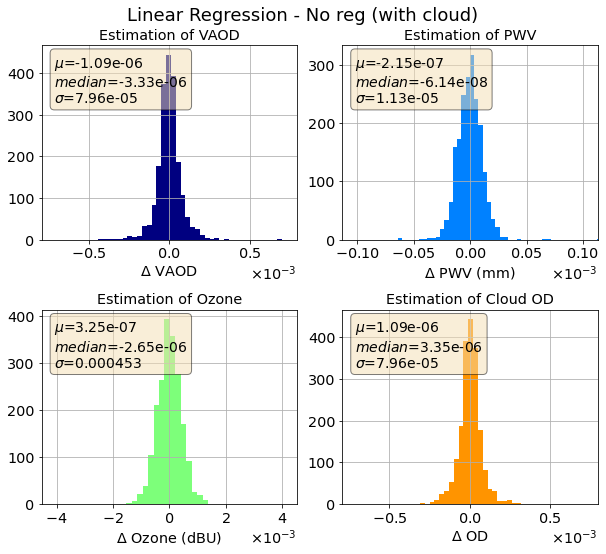

In [101]:
if FLAG_LINEARREGRESSION and FLAG_PLOT:
    plot_ml_result(Y_test, Y_pred_test_inv, mode=0, title="Linear Regression - No reg (with cloud)")
    plot_ml_result(Y_test, Y_pred_test_inv, mode=1, title="Linear Regression - No reg (with cloud)")
    plot_ml_result(Y_test, Y_pred_test_inv, mode=2, title="Linear Regression - No reg (with cloud)")
    #plot_ml_result(Y_test, Y_pred_test_inv, mode=3, title="Linear Regression - No reg (with cloud)")

    histo_ml_result(Y_test, Y_pred_test_inv, title="Linear Regression - No reg (with cloud)")

2020-09-22 21:35:59,661 MacBook-Pro-de-admin.local numexpr.utils[79321] INFO NumExpr defaulting to 8 threads.


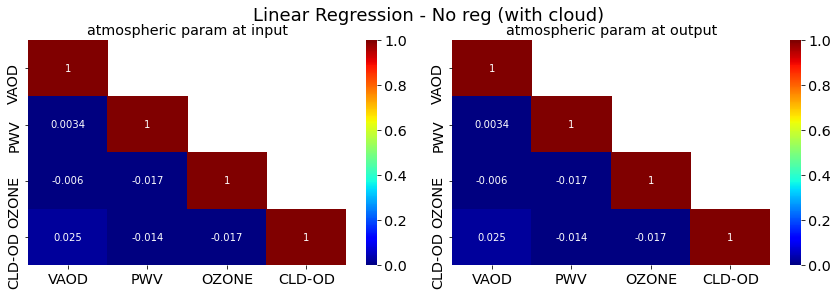

In [102]:
if FLAG_LINEARREGRESSION and FLAG_PLOT:
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(121)
    plotcorrelation(ax, Y_test)
    ax.set_title("atmospheric param at input")
    ax = fig.add_subplot(122)
    plotcorrelation(ax, Y_pred_test_inv)
    ax.set_title("atmospheric param at output")
    plt.tight_layout()
    plt.suptitle("Linear Regression - No reg (with cloud)", Y=1.02, fontsize=18)
    plt.show()

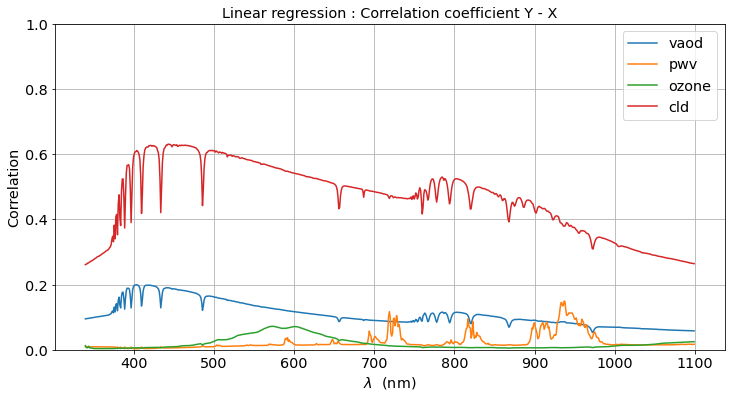

In [169]:
if FLAG_LINEARREGRESSION and FLAG_PLOT:
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111) 
    
    Ny=Y.shape[1]
    Nx=X.shape[1]
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl,corr[iy,:],label=Ylabel[iy])
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation")
    ax.set_title("Linear regression : Correlation coefficient Y - X")
    ax.grid()
    ax.set_ylim(0,1)

In [104]:
R=np.corrcoef(x=X[:,0], y=Y[:,0], rowvar=False)

In [105]:
R.shape

(2, 2)

In [106]:
R

array([[1.        , 0.09488884],
       [0.09488884, 1.        ]])

In [107]:
Y.shape

(10000, 4)

In [108]:
X.shape

(10000, 760)

In [109]:
R.shape

(2, 2)

# Linear Regression with Ridge

In [110]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [111]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[-1.59401631 -0.67010279 -0.24945384 ...  3.48201389  3.67016209
   3.94709495]
 [ 0.1732124   0.12443836  0.10099281 ... -0.26871529 -0.29313978
  -0.33405138]
 [ 1.3554949   0.6131558   0.30877072 ... -0.06557905 -0.08330666
  -0.10655476]
 [ 0.35252558  0.11935424  0.01268482 ... -0.94368889 -0.99375172
  -1.06752901]]
Mean squared error: 0.00001
Coefficient of determination: 0.99998
Explained variance: 0.99998


In [112]:
regr_ridge.coef_.shape

(4, 760)

## Tune hyper parameter with Ridge

In [113]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.02911e-19): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.20395e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.75758e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.58559e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.092e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagor

<Figure size 1080x1080 with 0 Axes>

In [114]:
allcoefs.shape

(200, 4, 760)

In [115]:
RIDGE_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [116]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [117]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

1e-10

1e-10

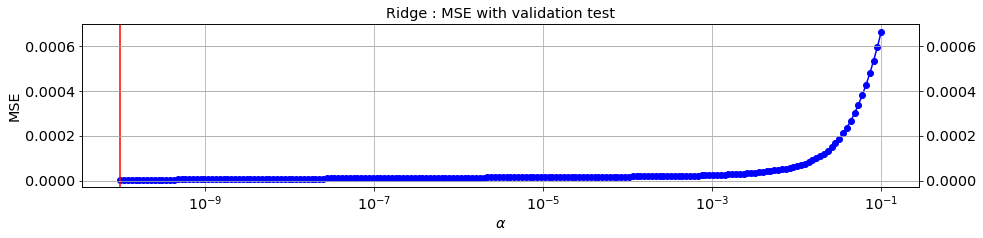

In [118]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
#if FLAG_MAG:
#    idx_min=np.where(all_MSE<1e-6)[0][-1]
#else:
#    idx_min=np.where(all_MSE<1e-6)[0][-1]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_ridge

### Display results

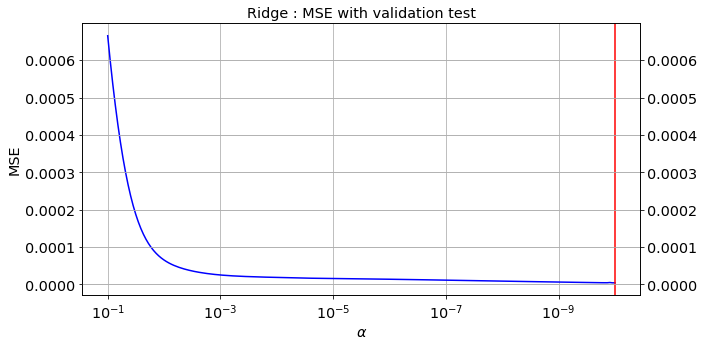

In [119]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
ax.grid()
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [120]:
allcoefs.shape

(200, 4, 760)

In [121]:
N=NWL
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

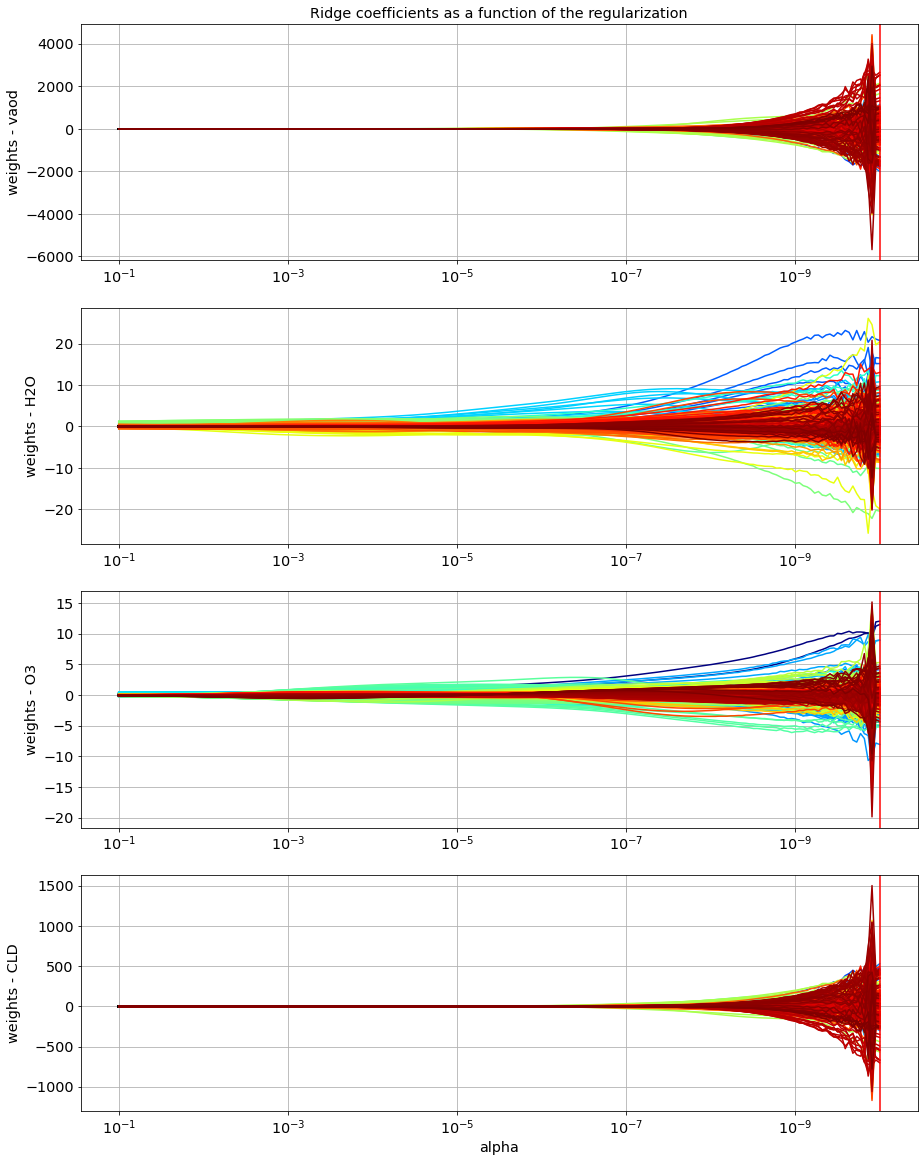

In [122]:
fig=plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.axvline(x=alpha_ridge,color='red')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.axvline(x=alpha_ridge,color='red')
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.axvline(x=alpha_ridge,color='red')
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax4.plot(alphas, allcoefs[:,3,idx],color=all_colors[idx])
ax4.axvline(x=alpha_ridge,color='red')
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.grid(True)


plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [123]:
from sklearn import linear_model

In [124]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [125]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434.5323594190758, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.26688600610693, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1680.0733027403055, tolerance: 0.6000000000000036
  positive)


Coefficients: 
 [[ 5.85795417e+00 -1.35732006e+00 -5.88348190e-01 ...  3.78778787e-03
   1.08374405e-02  3.91067057e-02]
 [ 9.95206905e-01 -3.91084891e-02 -2.08123343e-02 ... -2.32458164e-03
  -0.00000000e+00  3.24016010e-02]
 [-5.14227896e+00 -3.98604549e+00 -1.76227766e+00 ...  4.97371995e-02
   6.29857870e-02  9.60322949e-02]
 [-2.66549441e+00  4.33122931e-01  1.95911226e-01 ... -3.22794636e-03
  -5.67087904e-03 -9.62092223e-03]]
Mean squared error: 0.17857
Coefficient of determination: 0.81374
Explained variance: 0.81378


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.64685754829605, tolerance: 0.5999999999999999
  positive)


In [126]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.52152415018844, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.51907166437061, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1667.7037007606425, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1667.706899353531, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.59593902165729, tolerance: 0.5999999999999996
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.5286327075445, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.71119796646866, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.66325882913543, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1667.9643813896694, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1687.5519680775094, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.440520191858255, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440.0328377797519, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 916.7841242776001, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249.454334903115, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2162.2850216199568, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

<Figure size 1080x1080 with 0 Axes>

In [127]:
LASSO_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [128]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [129]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

0.003792690190732246

0.003792690190732246

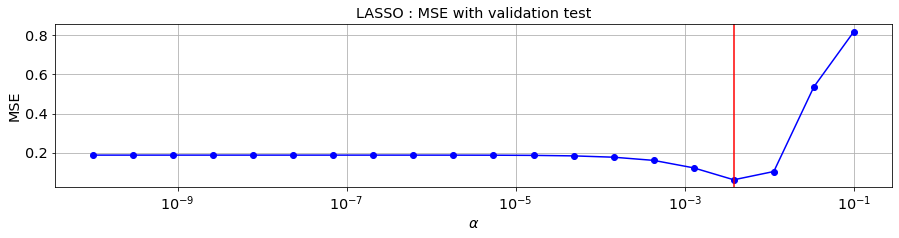

In [130]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
else:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
alpha_lasso

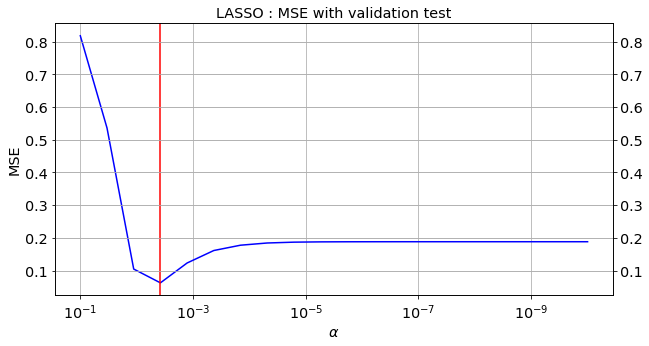

In [131]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

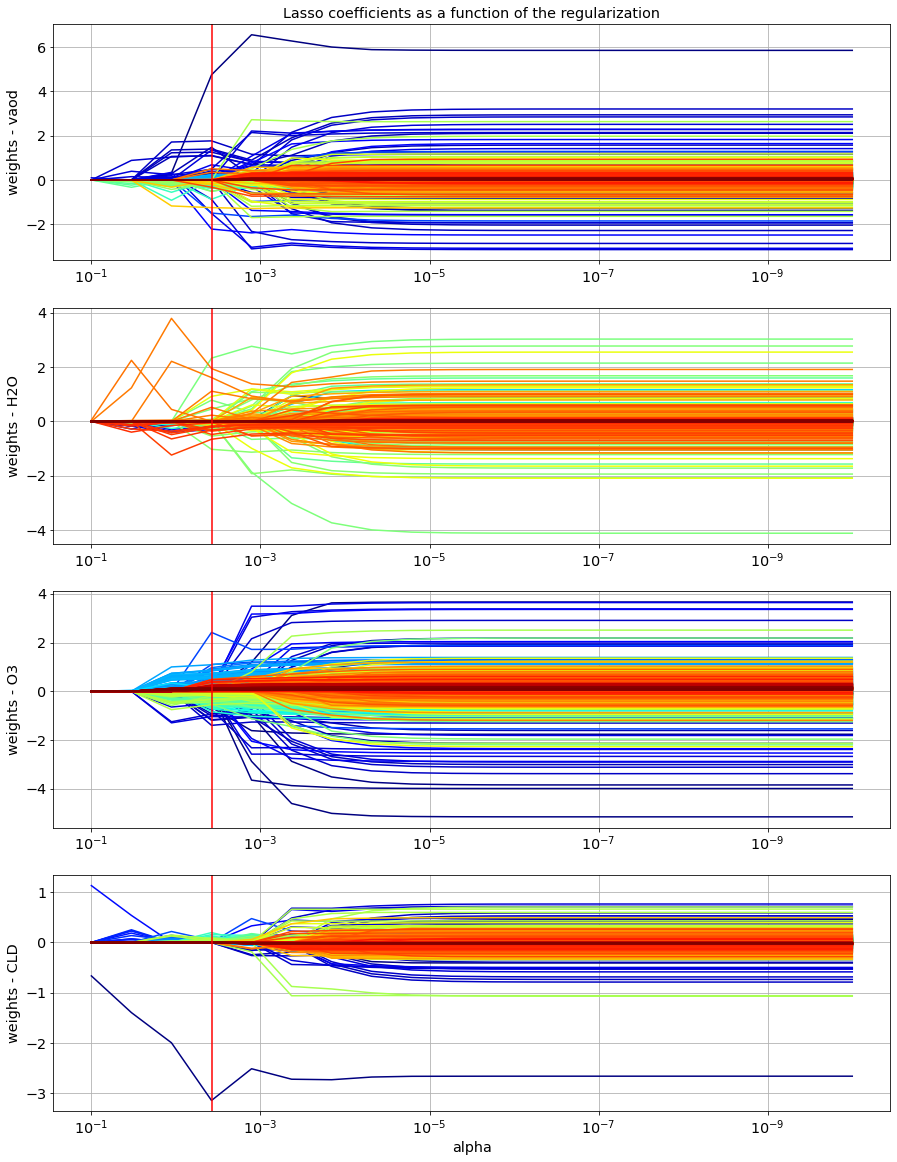

In [132]:
N=NWL
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

fig=plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.axvline(x=alpha_lasso,color='red')
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.axvline(x=alpha_lasso,color='red')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.axvline(x=alpha_lasso,color='red')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax4.plot(alphas, allcoefs2[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.axvline(x=alpha_lasso,color='red')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [133]:
nb_tot_test=len(Y_test)
nb_tot_train=len(Y_train)

In [134]:
nsamples_test=np.arange(10,nb_tot_test,100)
nsamples_train=np.arange(10,nb_tot_train,100)

### Leraning curves for linear regression

In [135]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [136]:
count=0
for n in nsamples_train:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    # does the fit    
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    if n in nsamples_test:
        Y_pred_test  = regr.predict(X_test_cut)
        
    if FLAG_SCALING:     
        Y_pred_test_full = regr.predict(np.copy(X_test_scaled))
    else:
        Y_pred_test_full = regr.predict(np.copy(X_test))
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)
        
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
         MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full) 
            
    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
        
    
    count+=1
    # end of loop
    

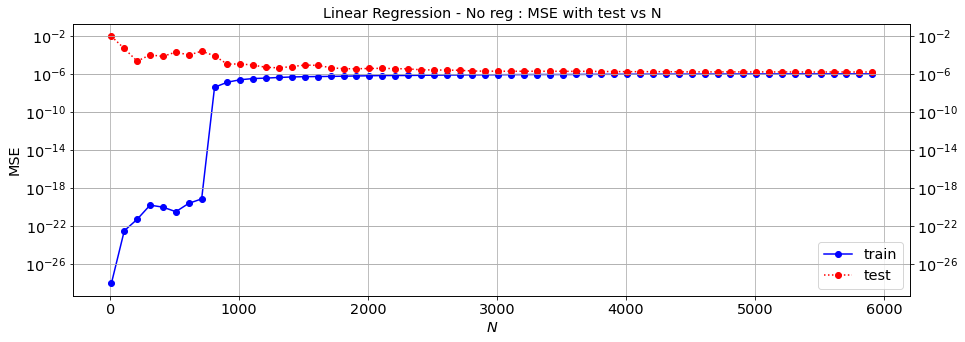

In [137]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r:o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Ridge

In [138]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [139]:
count=0
for n in nsamples_train:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = ridge.predict(X_test_scaled)
    else:
        Y_pred_test_full = ridge.predict(X_test)
        
        
    if n in nsamples_test:
        Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)   
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.61808e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.9598e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.11308e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.78355e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.33302e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/a

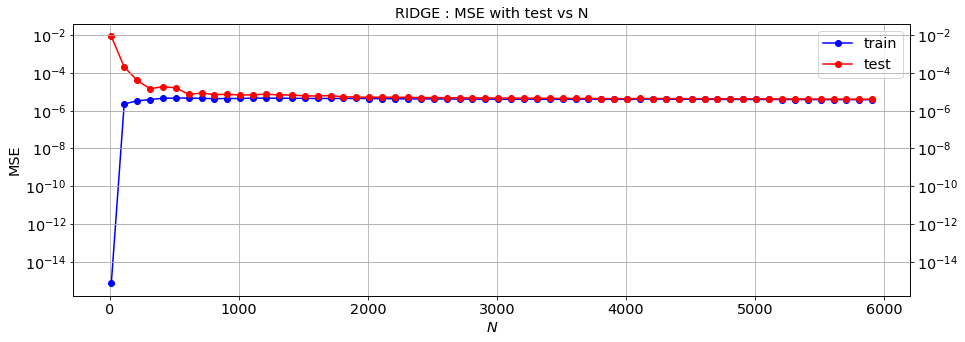

In [140]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [141]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [142]:
alpha_lasso

0.003792690190732246

In [143]:
alpha_lasso_min

0.003792690190732246

In [144]:
alpha_lasso_0=1e-3

In [145]:
count=0
for n in nsamples_train:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = lasso.predict(X_test_scaled)
    else:
        Y_pred_test_full = lasso.predict(X_test)
    
    if n in nsamples_test:
        Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)   
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4748127866752191, tolerance: 0.00028823314641822026
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17703933916967296, tolerance: 0.0003931938995739484
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0369881941805892, tolerance: 0.0007846834125749547
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You m

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 258.1848850080697, tolerance: 0.07272300963656848
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.271758302499515, tolerance: 0.0710987490928569
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114.59061558072534, tolerance: 0.0781204718293876
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217.45782935101536, tolerance: 0.14637882991200193
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.80286384709899, tolerance: 0.14551476274390052
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 551.635913481024, tolerance: 0.1555529856031648
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 803.8124317420367, tolerance: 0.22667697087166352
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.82268890165228, tolerance: 0.22746290002027336
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331.9643736404804, tolerance: 0.22331320658598333
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436.1240860781626, tolerance: 0.29591915566798255
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.95269930316485, tolerance: 0.302509945222891
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1101.2152230656961, tolerance: 0.3101091292964931
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1352.8431552187599, tolerance: 0.379202854601014
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.02312731478857, tolerance: 0.3716651934980084
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.2199330024503, tolerance: 0.3775798816718633
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 658.1358915861756, tolerance: 0.4561910001594176
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.6960359297123, tolerance: 0.4487924662892676
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1640.1628298570645, tolerance: 0.4599756957808217
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1873.8087640331055, tolerance: 0.5249297094489511
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.67331552347656, tolerance: 0.521483774114932
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.6827140354984, tolerance: 0.5356099839392289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

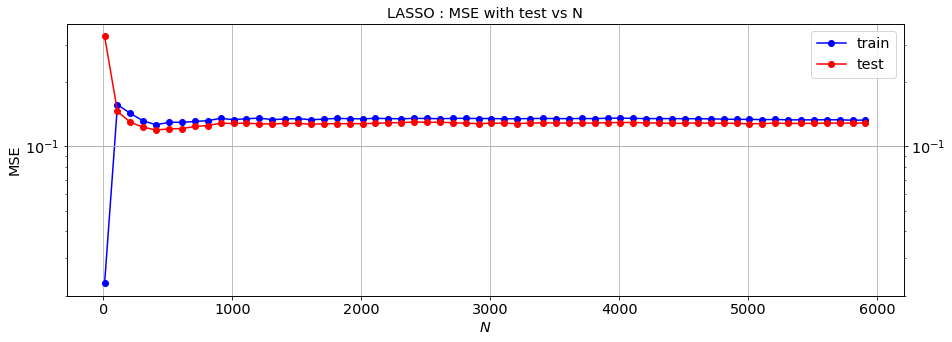

In [146]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [147]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [148]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


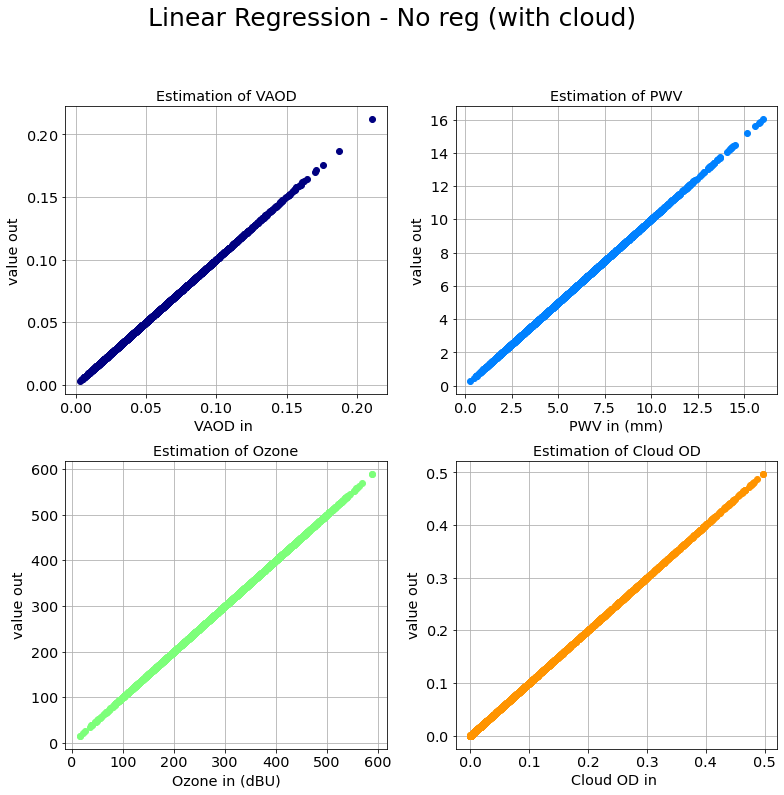

In [149]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

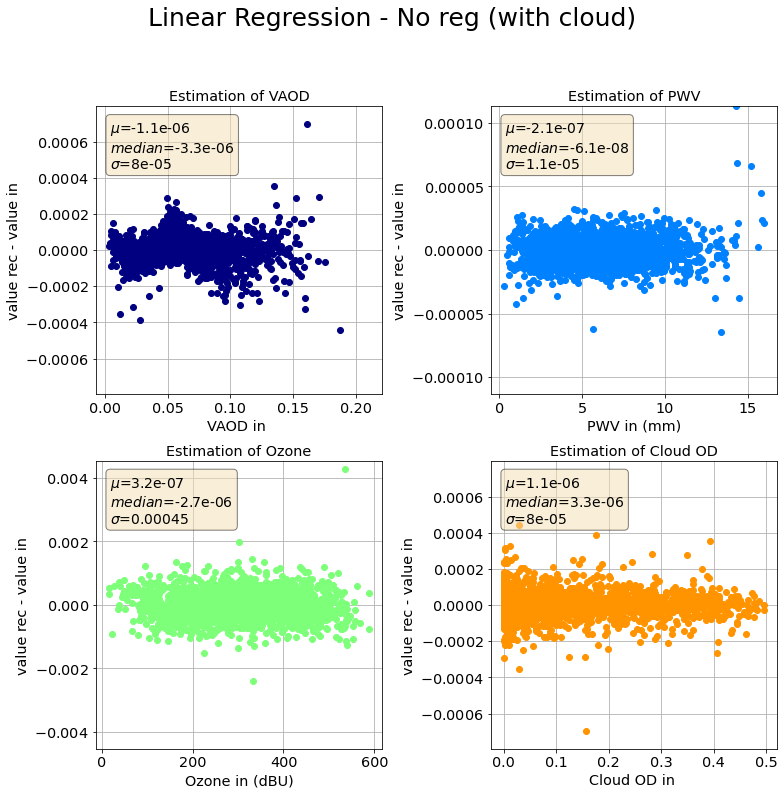

In [150]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

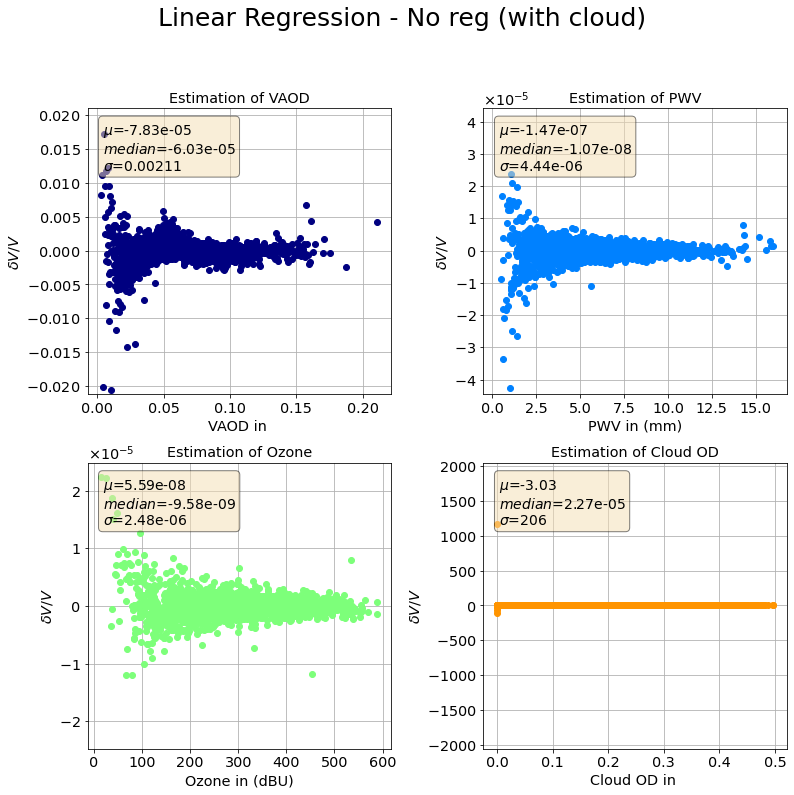

In [151]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

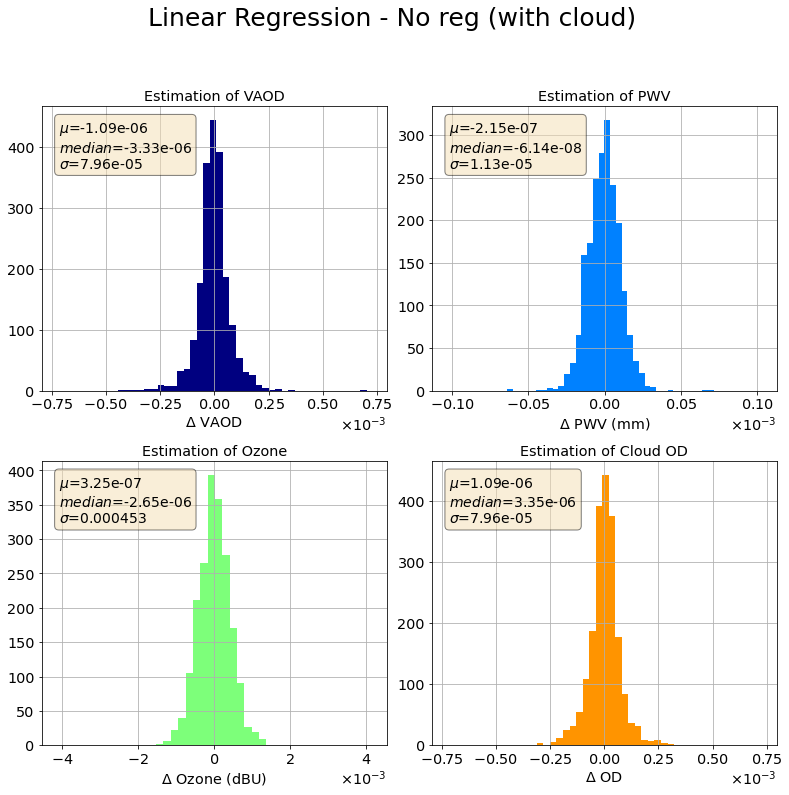

In [152]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()


Text(0.5, 1.05, 'Linear Regression - No reg (with cloud)')

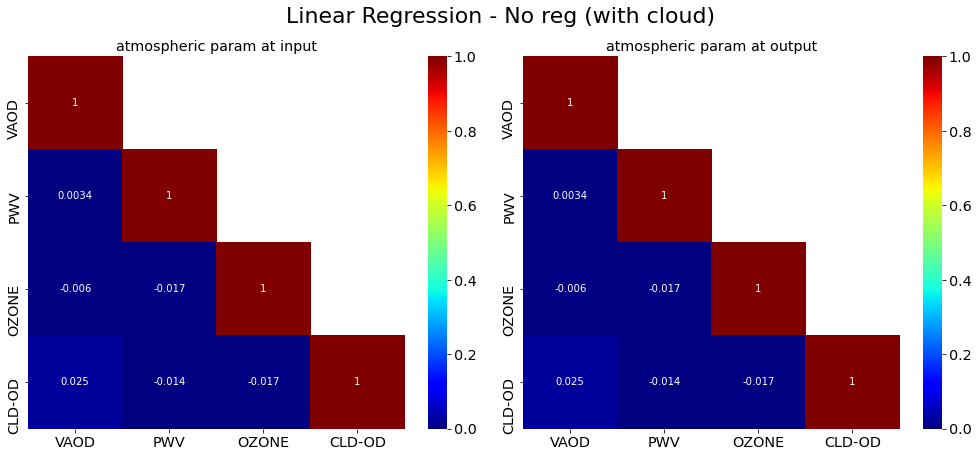

In [153]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.05,fontsize=22)

## Ridge

In [154]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [155]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


In [156]:
ridge.coef_

array([[-1.69036101e+03,  2.32005795e+02,  8.25760865e+02, ...,
         1.00787281e+03,  1.00288722e+03,  9.46049708e+02],
       [-5.34441690e+00,  7.93760322e-01, -1.77822126e-01, ...,
        -3.77918319e+00, -2.63444146e+00, -1.94017843e+00],
       [ 1.20474866e+01, -6.85385122e-01, -4.44517343e+00, ...,
         3.06114733e+00,  3.15721935e-01, -4.32298544e+00],
       [ 4.46752593e+02, -6.16527699e+01, -2.18664942e+02, ...,
        -2.66611693e+02, -2.65376838e+02, -2.50435963e+02]])

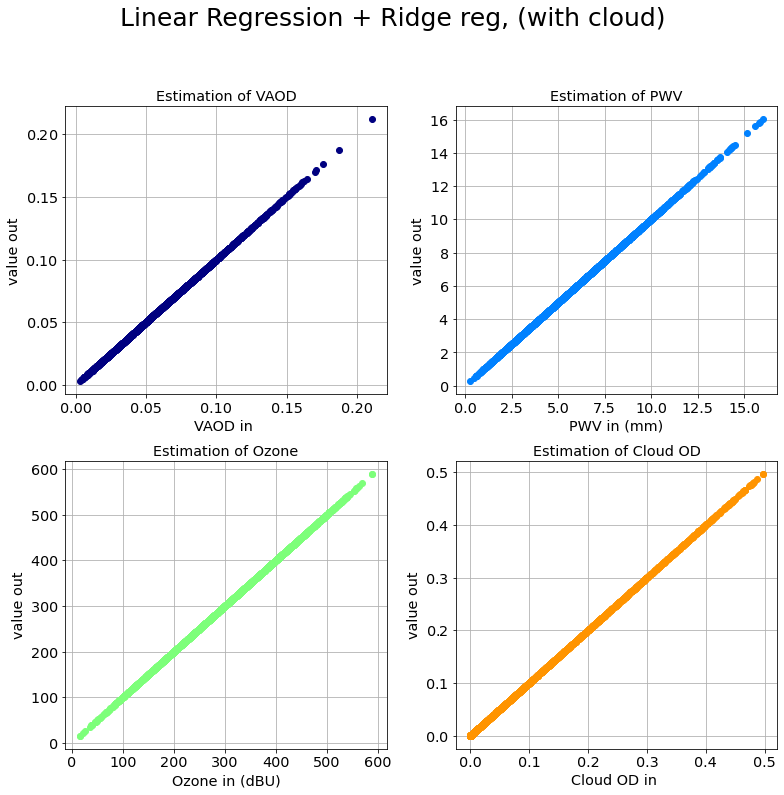

In [157]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

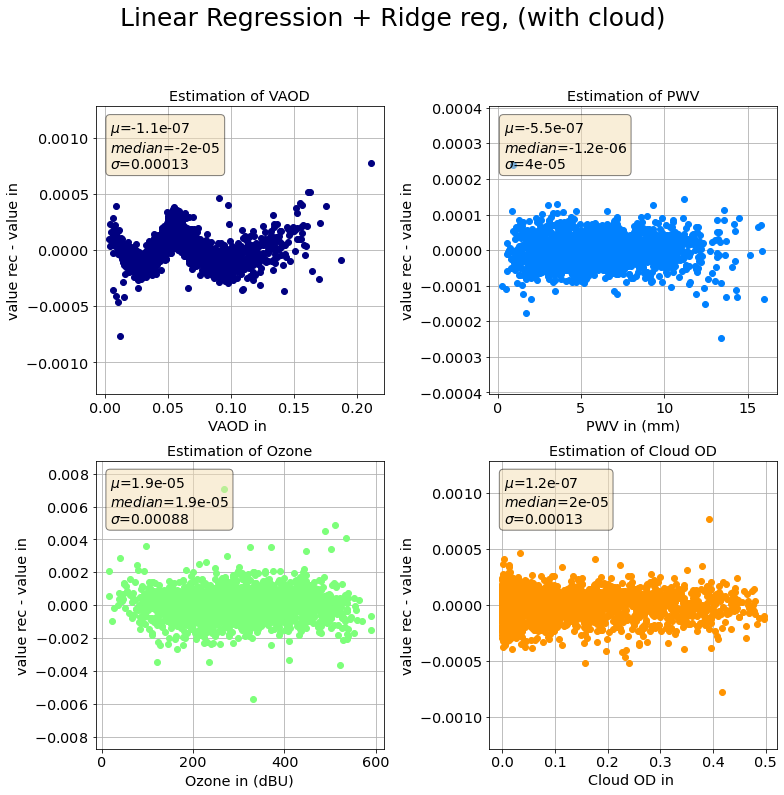

In [158]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

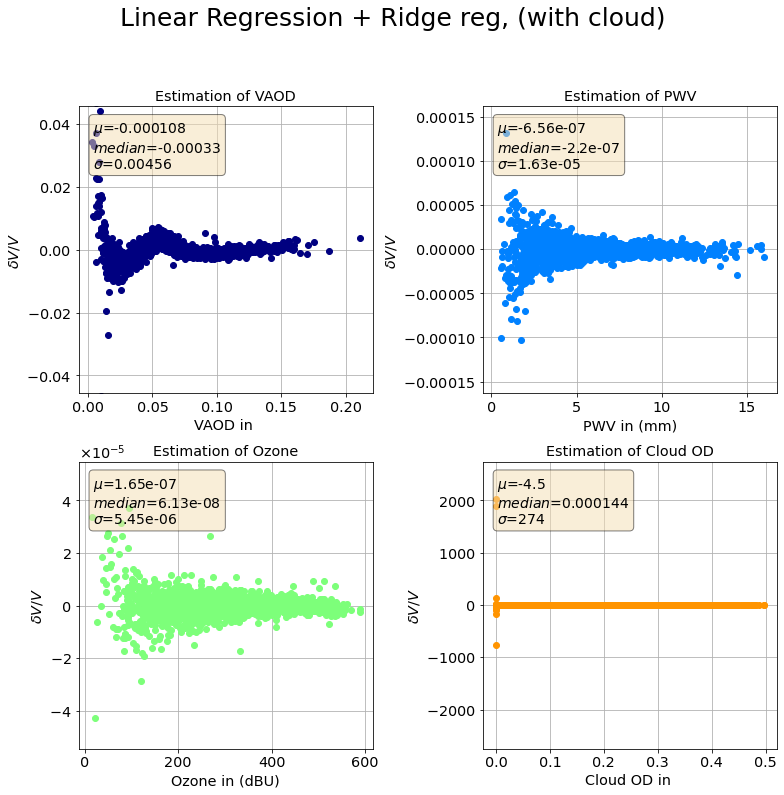

In [159]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

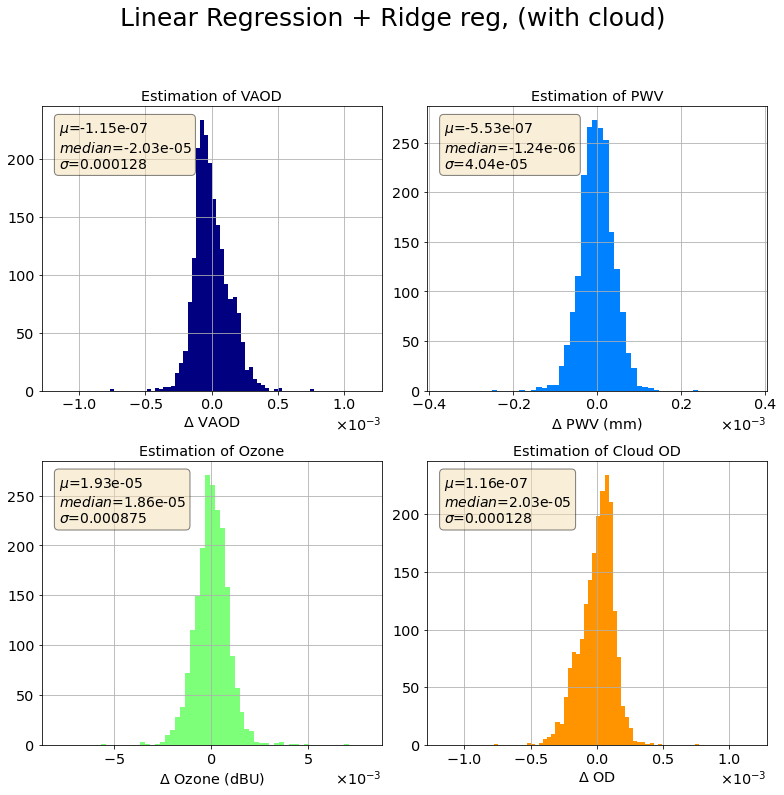

In [160]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

Text(0.5, 1.05, 'Linear Regression - Ridge (with cloud)')

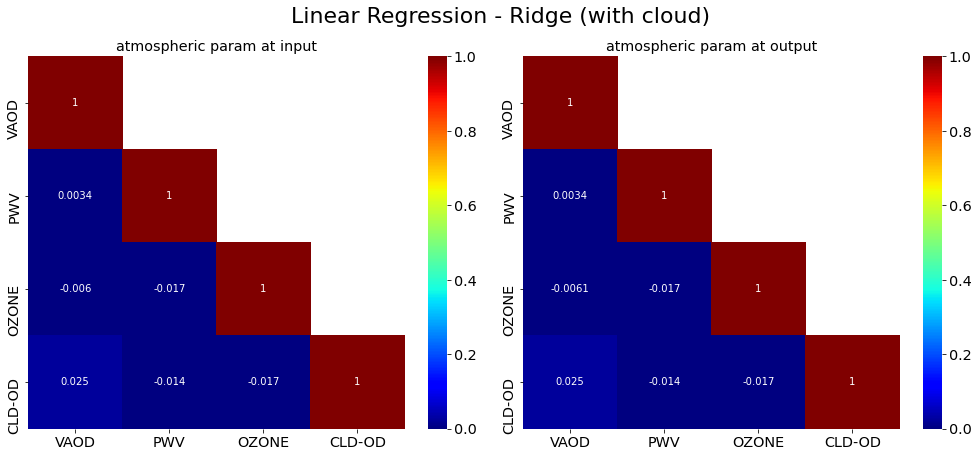

In [161]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - Ridge (with cloud)",Y=1.05,fontsize=22)

## Lasso

In [162]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1133.3810784666434, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.6115162090936, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2007.5682475862232, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

In [163]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.05948
Coefficient of determination: 0.93857
Explained variance: 0.93858


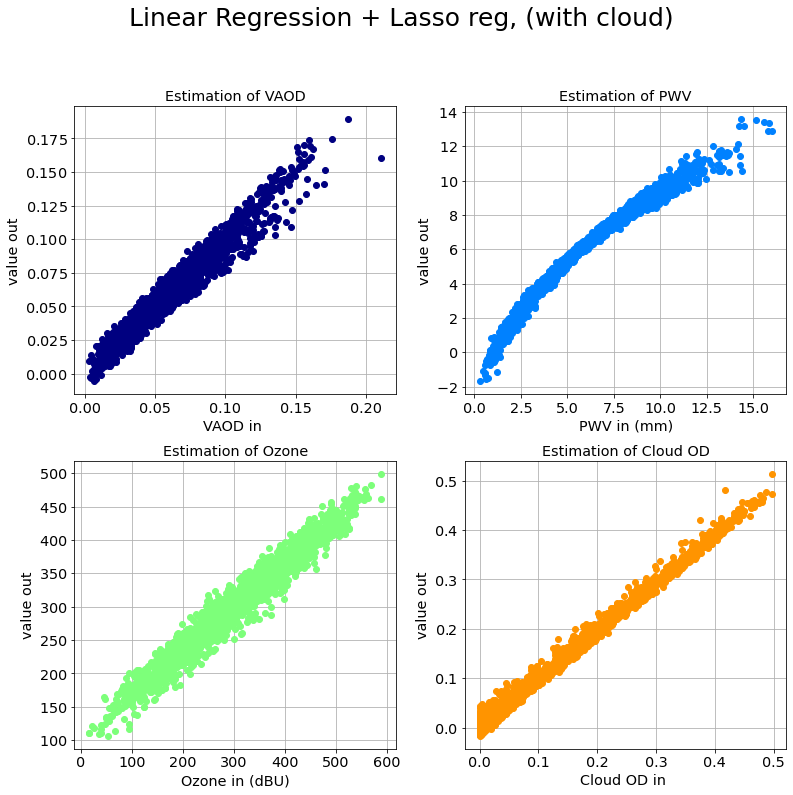

In [164]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

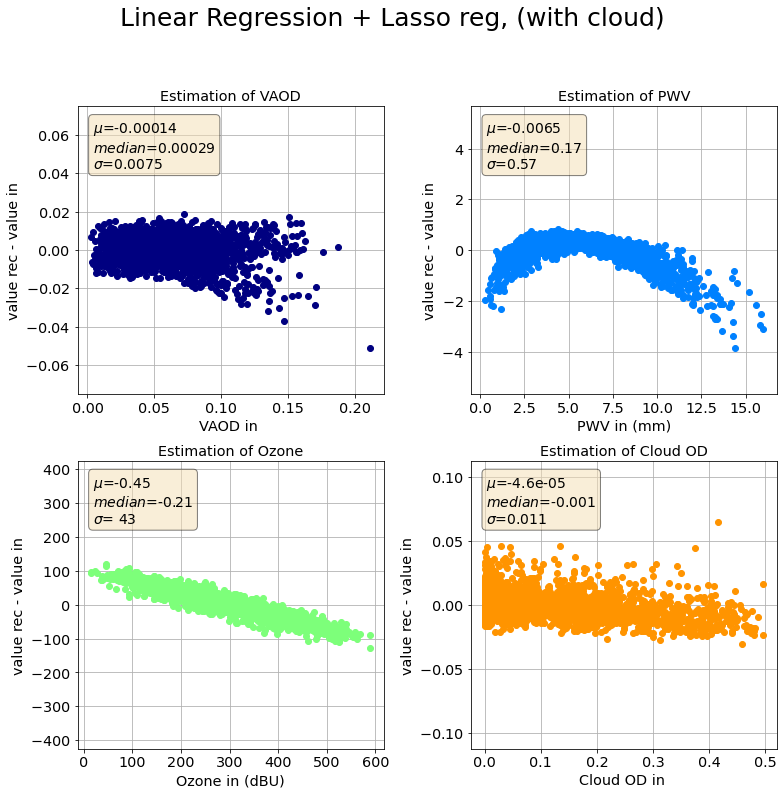

In [165]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

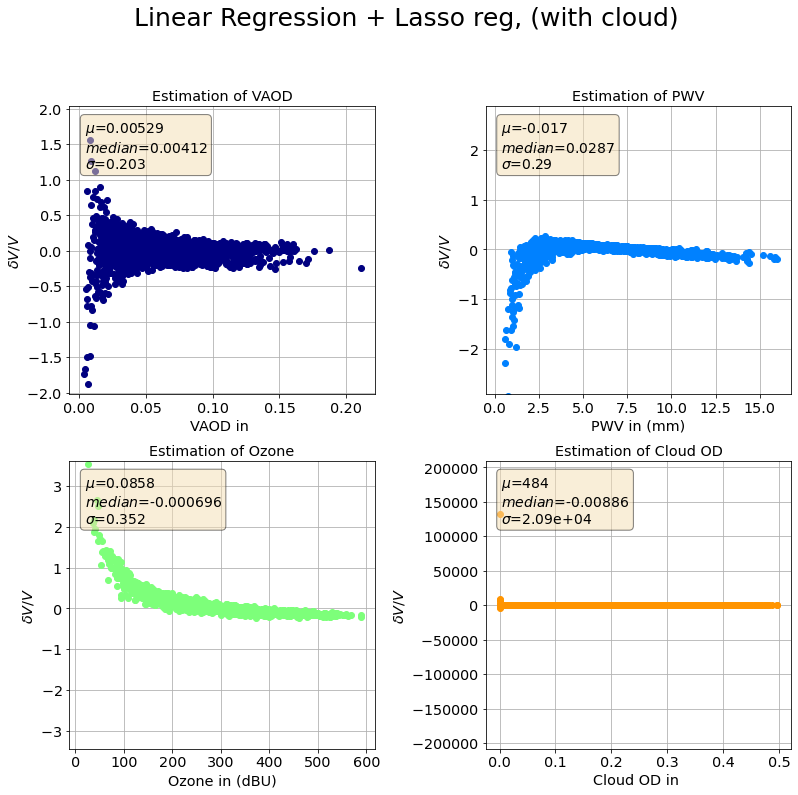

In [166]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

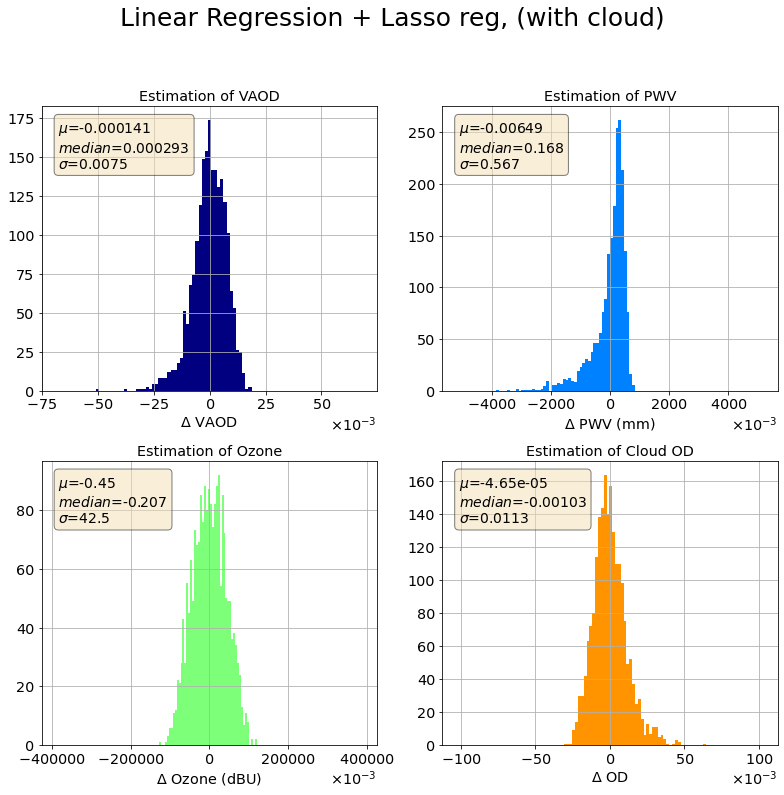

In [167]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

Text(0.5, 1.05, 'Linear Regression - Lasso (with cloud)')

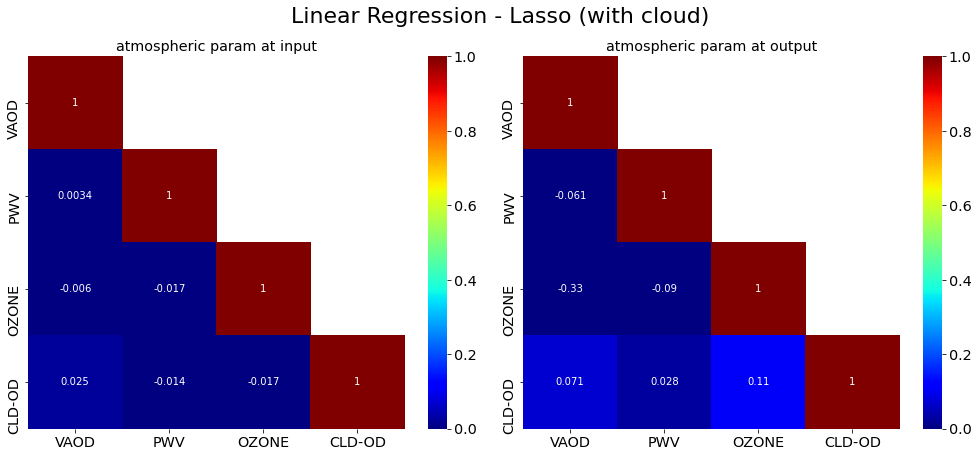

In [168]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - Lasso (with cloud)",Y=1.05,fontsize=22)